In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df_metadata = pd.read_csv("./Chest_xray_Corona_Metadata.csv", index_col=0)
df_summary = pd.read_csv("./Chest_xray_Corona_dataset_Summary.csv", index_col=0)

In [4]:
df_metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [5]:
df_summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


In [6]:
def sel_image_plot(label='Normal', idx=0):
    
    """
    Input: Label of the image we want to select.
           Index of the image we want to select.
    Output: Plot of an image.
    """
    
    try:
        image_list = df_metadata[(df_metadata['Label'] == label) & (df_metadata['Dataset_type'] == 'TRAIN')]
        image_name= image_list['X_ray_image_name'].reset_index(drop=True)[idx]
        plt.imshow(plt.imread('./Coronahack-Chest-XRay-Dataset/train/' + image_name))
        plt.title('X-Ray of a pacient with label \'{0}\' from the train dataset'.format(label))
        plt.show()
        
    except KeyError:
        print('Index not in range.')

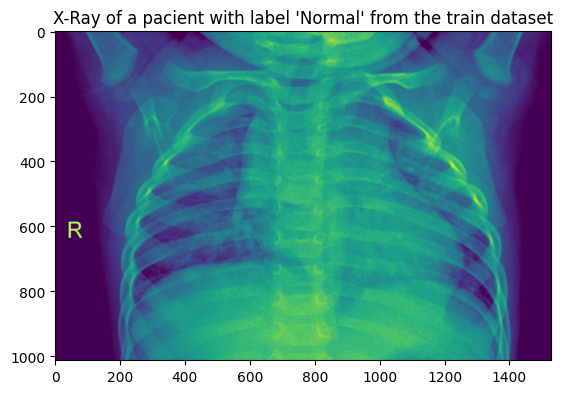

In [7]:
sel_image_plot(idx=0)

In [8]:
def sel_train_test(dataframe, train_test):
    
    """
    Inputs: Dataframe and a string (test or train).
    Outputs: Only the test or train examples in the dataframe.
    """
    
    dataframe_transformed = dataframe[dataframe['Dataset_type'] == train_test.upper()]
    
    return dataframe_transformed

In [9]:
PATH = './Coronahack-Chest-XRay-Dataset/'
BATCH_SIZE = 64

# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      validation_split=0.1,
      fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(150,150),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='training', 
                                                    directory=PATH + 'train/')


val_generator = train_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'train'),
                                                    x_col='X_ray_image_name',
                                                    y_col='Label',
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(150,150),
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True,
                                                    seed=1234,
                                                    subset='validation', 
                                                    directory=PATH + 'train/')

test_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)


test_generator = test_datagen.flow_from_dataframe(dataframe=sel_train_test(df_metadata, 'test'),
                                                  x_col='X_ray_image_name',
                                                  y_col='Label',
                                                  color_mode='rgb',
                                                  class_mode='binary',
                                                  target_size=(150,150),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False, 
                                                  directory=PATH + 'test/')

Found 4758 validated image filenames belonging to 2 classes.
Found 528 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [10]:
def model_inception():
    
    """
    Model InceptionV3.
    """
    
    inputs = tf.keras.layers.Input((150, 150, 3))
    base_model = tf.keras.applications.InceptionV3(include_top=False,
                                                 weights='imagenet',
                                                 input_shape=(150, 150, 3)) 
    x = base_model(inputs)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=output)

    return model

In [11]:
model = model_inception()

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 26521889 (101.17 MB)
Trainable params: 26487457 (101.04 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________


In [13]:
model.compile(loss='binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adamax(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50


I0000 00:00:1710443858.541445  163700 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 [==============================] - 62s 517ms/step - loss: 0.3388 - accuracy: 0.8581 - val_loss: 6.4650 - val_accuracy: 0.0000e+00
Epoch 2/50
75/75 [==============================] - 30s 395ms/step - loss: 0.1653 - accuracy: 0.9338 - val_loss: 4.7112 - val_accuracy: 0.0057
Epoch 3/50
75/75 [==============================] - 28s 366ms/step - loss: 0.1312 - accuracy: 0.9506 - val_loss: 4.5082 - val_accuracy: 0.0208
Epoch 4/50
75/75 [==============================] - 27s 364ms/step - loss: 0.1075 - accuracy: 0.9609 - val_loss: 4.8862 - val_accuracy: 0.0246
Epoch 5/50
75/75 [==============================] - 30s 395ms/step - loss: 0.0953 - accuracy: 0.9645 - val_loss: 4.0022 - val_accuracy: 0.0568
Epoch 6/50
75/75 [==============================] - 30s 394ms/step - loss: 0.0900 - accuracy: 0.9678 - val_loss: 2.9796 - val_accuracy: 0.1477
Epoch 7/50
75/75 [==============================] - 27s 364ms/step - loss: 0.0915 - accuracy: 0.9662 - val_loss: 1.8512 - val_accuracy: 0.3580
Epoch 

Text(0, 0.5, 'Accuracy')

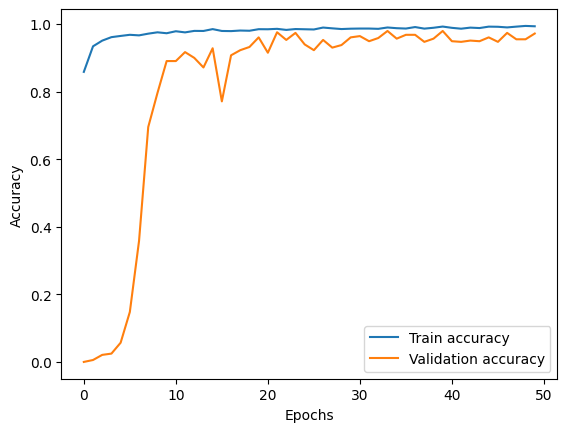

In [14]:
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

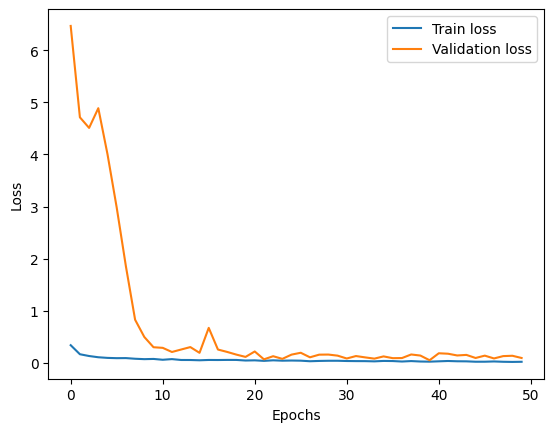

In [15]:
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [16]:
predictions = model.predict(test_generator)

10/10 [==============================] - 5s 415ms/step


In [17]:
predictions = (predictions > 0.5).astype(int).reshape(-1,)

In [18]:
true_labels = [False if x=="Normal" else True for x in sel_train_test(df_metadata, 'test')["Label"]]

In [19]:
print("Results on test set:")
print(classification_report(true_labels, predictions, target_names=["Normal", "Pnemonia"]))
print("ROC AUC score:   ",roc_auc_score(true_labels, predictions))
print("F1 score:", f1_score(true_labels, predictions))

Results on test set:
              precision    recall  f1-score   support

      Normal       0.90      0.90      0.90       234
    Pnemonia       0.94      0.94      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624

ROC AUC score:    0.92008547008547
F1 score: 0.9396662387676508


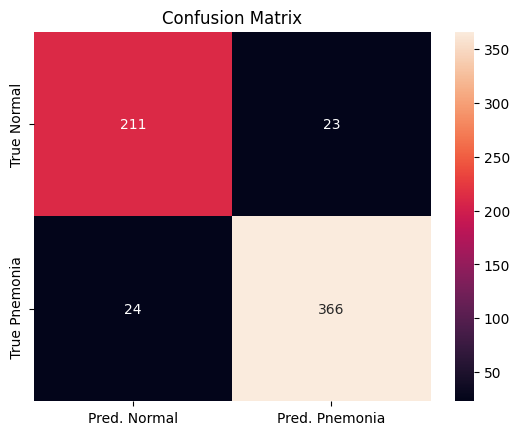

In [20]:
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix,
            xticklabels = ["Pred. Normal", "Pred. Pnemonia"],
            yticklabels =["True Normal", " True Pnemonia"],
            annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.show()